# Results interpretation


In [264]:
import sklearn

import gpflow, pickle
import numpy as np
from sklearn import preprocessing

import os, sys

sys.path.append('../')

from gpflow_wrapper import GPMaximizer

In [265]:
from collections import OrderedDict

In [266]:
import matplotlib.pyplot as plt
%matplotlib inline

In [267]:
last_file = sorted(os.listdir('../logs'))[-1]
with open('../logs//'+last_file, 'r') as f:
    read_lines = f.read()

In [268]:
delim1 = 'INFO:root:init:system_params:'
delim2 = 'INFO:root:init:channel_rates:'
delim3 = 'INFO:root:init:model_params:'
delim4 = 'INFO:root:sequential:channel_rates='
delim5 = 'INFO:root:sequential:system_params='
delim6 = 'INFO:root:sequential:model_qualities='


X_init = np.vstack(eval(read_lines.split(delim1)[1].split(delim2)[0].replace('\n','').replace('array', 'np.array')) )
Y_init = np.array(eval(read_lines.split(delim3)[0].split(delim2)[1].replace('\n','')))






param_bounds_dict = OrderedDict({
                                        'freq':  (2.457E09,), # frequency is fixed for smooth kernel to work #(2.4E09, 2.5E09),
                                  'rx_if_gain': (0, 40),
                                 'rx_vga_gain': (0, 62),
                                 'tx_vga_gain': (0, 47),
                                 'sensitivity': (0, 1)
                                })
param_bounds = list(param_bounds_dict.values())

Y = [[y] for y in eval(read_lines.split(delim4)[1].split(delim5)[0].replace('\n','').replace('array', 'np.array'))]
Y = np.array(Y)

X = eval(read_lines.split(delim5)[1].split(delim6)[0].replace('\n','').replace('array', 'np.array'))

X = np.vstack(X)

In [288]:
class BoundsScaler():
    """ Scaler based on strict bounds for variables, it scales each bound to [-1,1]
    If variable is single-valued it's scaled to 0."""
    def __init__(self, param_bounds):
        self.param_bounds = param_bounds

    def fit(self, X):  # just for compatibility with 'sklearn.preprocessing.StandardScaler'
        pass

    def transform(self, X):

        X = X.copy()
        for j, bnds in enumerate(self.param_bounds):

            if len(bnds) == 1:
                X[:, j] = 0

            if len(bnds) == 2:
                L_bnds = bnds[1] - bnds[0]
                X[:, j] = 2 * (X[:, j] - bnds[0]) / L_bnds - 1

        return X

    def inverse_transform(self, X):
        X = X.copy()
        for j, bnds in enumerate(self.param_bounds):

            if len(bnds) == 1:
                X[:, j] = bnds[0]

            if len(bnds) == 2:
                L_bnds = bnds[1] - bnds[0]
                X[:, j] = bnds[0] + L_bnds * (1 + X[:, j]) / 2

        return X

In [289]:
BoundsScaler_ = BoundsScaler(param_bounds)

In [293]:
X__ = BoundsScaler_.transform(X)

In [269]:
Y

array([[ 1.],
       [ 4.],
       [ 8.],
       [12.],
       [ 8.],
       [ 6.],
       [ 8.],
       [15.],
       [10.],
       [10.],
       [ 1.],
       [ 5.],
       [ 9.],
       [ 8.],
       [ 5.],
       [ 7.],
       [10.],
       [ 8.],
       [ 7.],
       [ 9.]])

In [270]:
Y_init

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [7.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [2.],
       [0.],
       [7.],
       [0.],
       [0.],
       [5.]])

Text(0.5, 0, 'search step')

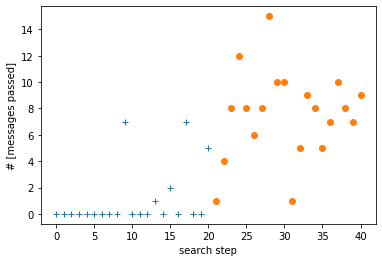

In [275]:
N_total_points = Y_init.shape[0] +  Y.shape[0] 


X_init_indcs = [j for j in range(Y_init.shape[0])]  
X_sequential_indcs = [j for j in range(Y_init.shape[0], N_total_points)] 
plt.plot(X_init_indcs,Y_init, '+')
plt.plot(X_sequential_indcs, Y,'o')
plt.ylabel('# [messages passed]')
plt.xlabel('search step')

Text(0, 0.5, 'distance to the last point')

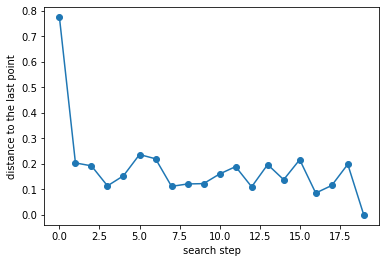

In [296]:
#CONVERGENCE TO FINAL POINT

plt.plot(np.linalg.norm(X__ - X__[-1,:], axis = 1), '-o')
plt.xlabel('search step')
plt.ylabel('distance to the last point')


In [204]:
N_msgs = 10000  # quantity of messages send per each channel rate testing
N_init_points = 5  # quantity of initial points required to build a model
# TODO: criterion to choose N_init_points (perhaps, we better need to reach some model quality)
# TODO: add early detection of zero-rate points, less than N_msgs should be spent on them

N_sequential = 20  # quantity of sequential search trials
N_search = 10000  # quantity of search points per trial (quantity of (mean, var) estimates)
gauss_thr = 2  # controls filtering of channel_rates close to zero
kappa = -1  # determines how new points are chosen -- either mean or variance is preferred
            # point with largest (mean + kappa*var) is chosen

In [205]:
GPMaximizer_ = GPMaximizer(param_bounds, N_init_points, N_search)

In [206]:
Y_init - np.mean(Y_init, axis = 0)

array([[-1.55],
       [-2.55],
       [10.45],
       [-2.55],
       [ 7.45],
       [-2.55],
       [-2.55],
       [-2.55],
       [ 5.45],
       [ 3.45],
       [-2.55],
       [-2.55],
       [-2.55],
       [-2.55],
       [ 5.45],
       [ 1.45],
       [-2.55],
       [-2.55],
       [-1.55],
       [-2.55]])

In [207]:
#Y_init = Y_init - np.mean(Y_init, axis = 0)
GPMaximizer_.init_scaler(X_init)
GPMaximizer_.learn_gp_model(X_init,Y_init)

-1.7675447221394207

In [208]:
GPMaximizer_.model_params(format='dict')

{'kernel.length': array(1.30447352),
 'kernel.variance': array(14.93193396),
 'noise.variance': array(2.687435)}

In [209]:
Y= Y - np.mean(Y, axis = 0)

In [210]:
Y
#X

array([[ 3.45],
       [ 2.45],
       [ 0.45],
       [ 1.45],
       [-2.55],
       [ 5.45],
       [-2.55],
       [ 0.45],
       [-3.55],
       [-0.55],
       [ 0.45],
       [ 3.45],
       [-1.55],
       [-2.55],
       [ 2.45],
       [-1.55],
       [-0.55],
       [ 2.45],
       [-4.55],
       [-2.55]])

In [211]:
GPMaximizer_.init_scaler(X_init)

In [212]:
#GPMaximizer_.learn_gp_model(X,Y)

-2.3881294726259705

In [213]:
X_scaled = GPMaximizer_.scaler.transform(X_init)
X_scaled[0] - X_scaled[1]
#X_init[0], X_init[1]
X_init

array([[2.45700000e+09, 2.45325547e+01, 2.71208884e+01, 3.82214023e+01,
        2.90001969e-01],
       [2.45700000e+09, 2.89201195e+01, 1.25457304e+01, 3.57521271e+01,
        4.00289224e-01],
       [2.45700000e+09, 2.27381165e+01, 6.13028881e+01, 3.13351473e+01,
        2.18480124e-01],
       [2.45700000e+09, 1.44836619e+01, 7.12603554e+00, 8.37160944e+00,
        7.35316460e-01],
       [2.45700000e+09, 2.78651388e+01, 3.84943226e+01, 2.44148308e+01,
        5.40228659e-01],
       [2.45700000e+09, 3.44428608e+00, 2.57382989e+01, 4.67901677e+01,
        4.52186857e-01],
       [2.45700000e+09, 2.98761395e+01, 2.59373796e+01, 2.12103620e+00,
        6.82065189e-02],
       [2.45700000e+09, 1.36439188e+01, 3.40046595e+01, 3.98530704e+01,
        3.21355573e-01],
       [2.45700000e+09, 3.09760834e+01, 4.35643943e+01, 2.73875278e+01,
        6.46188578e-01],
       [2.45700000e+09, 2.15305730e+01, 5.55852372e+01, 3.71617488e+01,
        6.41089418e-01],
       [2.45700000e+09, 3.3748

In [232]:
Y_init


array([[ 1.],
       [ 0.],
       [13.],
       [ 0.],
       [10.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 8.],
       [ 6.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 8.],
       [ 4.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.]])

In [233]:
Y

array([[ 3.45],
       [ 2.45],
       [ 0.45],
       [ 1.45],
       [-2.55],
       [ 5.45],
       [-2.55],
       [ 0.45],
       [-3.55],
       [-0.55],
       [ 0.45],
       [ 3.45],
       [-1.55],
       [-2.55],
       [ 2.45],
       [-1.55],
       [-0.55],
       [ 2.45],
       [-4.55],
       [-2.55]])